# Action potential: putting $Na^{+}$ and $K^{+}$ channels together

Now that we saw how to model the $Na^{+}$ and $K^{+}$ channels, we can put them together and run current clamp experiments to actually generate action potentials.

First we do the usual imports, create containers for model and data.

In [1]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose


# Create containers
container = moose.Neutral('/sim')
model = moose.Neutral('/sim/model')
data =  moose.Neutral('/sim/data')

Then we create compartment representing the squid giant axon. *Notice that we did not bother with the length and diameter in these examples. As long as everything is expressed in consistent scale (here specific values: specific capacitance, specific resistance, specific conductance for the channels), the numerical results will be consistent.

In [2]:
# Create a compartment representing the squid giant axon
axon = moose.Compartment(f'{model.path}/axon')
axon.Em = 0    # Hodgkin and Huxley used resting voltage as 0
axon.initVm = 0
axon.Cm = 1
axon.Rm = 1 / 0.3   # G_leak is 0.3 mS/cm^2

We copy the code for creating the $K^{+}$ channel from the K-channel notebook.

In [3]:
# Create K channel and connect it to the compartment
kchan = moose.HHChannel(f'{axon.path}/K')
moose.connect(kchan, 'channel', axon, 'channel')


kchan.Ek = -11.9998   # mV with respect to resting Vm
# Gbar is maximum conductance. 
# The voltage dependent conductance value is computed and 
# stored in the field Gk, which we record in a table below
kchan.Gbar = 36.0  # mS/cm^2

kchan.Xpower = 4    # Gbar is multiplied by 4-th power of n: Gbar_K * n^4 

n_gate = moose.HHGate(f'{kchan.path}/gateX')
# gate.useInterpolation = True   # use a lookup table for alpha and beta


vdivs = 150
vmin = -30.0
vmax = 120.0

# Mapping alpha_n(V) = 0.01 * (-V + 10)/[exp((-V+10)/10) - 1] to the form
# y(x) = (A + Bx)/(C + exp((D+x)/F))
n_alpha_params = [0.1, -0.01, -1.0, -10.0, -10.0]

# Mapping beta_n(V) = 0.125 * exp(-V/80) to the form
# y(x) = (A + Bx)/(C + exp((D+x)/F))
n_beta_params = [0.125, 0, 0, 0, 80.0]

# Note that `+` operator with lists as operands concatenates them
n_params = n_alpha_params + n_beta_params + [vdivs, vmin, vmax]
n_gate.setupAlpha(n_params)

True

In [4]:
# Create Na channel and connect it to the compartment
nachan = moose.HHChannel(f'{axon.path}/Na')
moose.connect(nachan, 'channel', axon, 'channel')
nachan.Ek = 114.9975   # mV with respect to resting Vm
# Gbar is maximum conductance. 
# The voltage dependent conductance value is computed and 
# stored in the field Gk, which we record in a table below
nachan.Gbar = 120.0  # mS/cm^2

# G_Na = Gbar_Na * m^3 * h
# X gate corresponds to m in HH paper, and has power 3
nachan.Xpower = 3
# Y gate corresponds to h in HH paper, and has power 1
nachan.Ypower = 1


m_gate = moose.HHGate(f'{nachan.path}/gateX')

# Mapping alpha_m(V) = 0.1 * (-V + 25)/[exp((-V+25)/10) - 1] to the form
# y(x) = (A + Bx)/(C + exp((D+x)/F))
m_alpha_params = [2.5, -0.1, -1.0, -25.0, -10.0]
# Mapping beta_m(V) = 4 * exp(-V/18) to the form
# y(x) = (A + Bx)/(C + exp((D+x)/F))
m_beta_params = [4, 0, 0, 0, 18.0]
# Note that `+` operator with lists as operands concatenates them
m_params = m_alpha_params + m_beta_params + [vdivs, vmin, vmax]
m_gate.setupAlpha(m_params)

h_gate = moose.HHGate(f'{nachan.path}/gateY')

# Mapping alpha_h(V) = 0.07 * exp(-V/20) to the form
# y(x) = (A + Bx)/(C + exp((D+x)/F))
h_alpha_params = [0.07, 0, 0, 0, 20.0]
# Mapping beta_h(V) = 1 / [exp((-V + 30) / 10) + 1] to the form
# y(x) = (A + Bx)/(C + exp((D+x)/F))
h_beta_params = [1, 0, 1, -30, -10.0]

# Note that `+` operator with lists as operands concatenates them
h_params = h_alpha_params + h_beta_params + [vdivs, vmin, vmax]
h_gate.setupAlpha(h_params)

True

We also create a pulse generator to inject a current pulse into the axon

In [6]:
pulse = moose.PulseGen(f'{model.path}/pulse')
moose.connect(pulse, 'output', axon, 'injectMsg')

<moose.SingleMsg id=5 dataIndex=2 path=/Msgs[0]/singleMsg[2]>

And finally, setup data recording. We shall record the voltage in the table `/data/Vm`, the $Na^{+}$ conductance (here conductivity because we are using specific values for everything, i.e., our compartment has unit length and unit surface area) in the table `/data/gNa` and the $K^{+}$ conductance in the table `/data/gK`.

In [7]:
gNa_tab = moose.Table(f'{data.path}/gNa')
moose.connect(gNa_tab, 'requestOut', nachan, 'getGk')
gK_tab = moose.Table(f'{data.path}/gK')
moose.connect(gK_tab, 'requestOut', kchan, 'getGk')
vm_tab = moose.Table(f'{data.path}/Vm')
moose.connect(vm_tab, 'requestOut', axon, 'getVm')

<moose.SingleMsg id=5 dataIndex=5 path=/Msgs[0]/singleMsg[5]>

In [8]:
## Uncomment below if you see an initial voltage transient when repeating the simulation

# simdt = 1e-5   # simulation timestep
# plotdt = 1e-3  # data collection timestep

# moose.setClock(0, simdt)
# moose.setClock(1, simdt)
# moose.setClock(2, simdt)
# moose.setClock(3, plotdt)

# # moose uses `#` character as a wildcard. 
# # "/model/#" gets all objects that are children of `/model`.
# # "/model/#[TYPE=Compartment]" gets all `Compartment` instances that are children of `/model`.
# # "/model/##" gets all objects that are descendants (children, grand children, ...) of `/model`.

# moose.useClock(0, f'{model.path}/#[TYPE=Compartment]', 'init')
# moose.useClock(1, f'{pulse.path}', 'process')
# moose.useClock(1, f'{model.path}/#[TYPE=Compartment]', 'process')
# moose.useClock(2, f'{axon.path}/#[TYPE=HHChannel]', 'process')
# moose.useClock(3, f'{data.path}/#[TYPE=Table]', 'process')

In [9]:
# Modify this to see effect of different current amplitudes
pulse.delay[0] = 10.0  # start current pulse at 10 ms
pulse.level[0] = 20    # give 20 uA/cm^2 current injection
pulse.width[0] = 90    # deliver 90 ms
pulse.baseLevel = 0    # no baseline current

Text(0, 0.5, 'Membrane potential (mV)')

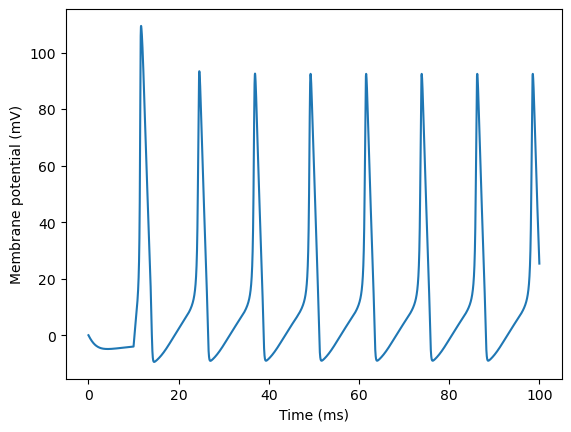

In [10]:
runtime = 100
# `reinit` initialize the simulation 
moose.reinit()
# run the simulation for `runtime` duration
moose.start(runtime)

# Plot the voltage
plt.plot(np.arange(len(vm_tab.vector)) * vm_tab.dt, vm_tab.vector)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')

## Exercises

1. Change the amplitude of the injected current from $1 \mu A/cm^{2}$ till $100 \mu A/cm^{2}$ in small steps and count how many spikes occur in each case. What do you observe?

2. Try to pinpoint the current amplitude for which you start to get spike. Show what you tried, and try to explain your observation.

3. You can obtain the gate variables, $m$, $h$, and $n$ by tapping into the `HHChannel` objects. The gate variables are computed and stored as `X` and `Y` fields in the channel. Therefore you can collect the values of $n$ by attaching a table like this:
   
    ```python
        moose.connect(ntab, 'requestOut', kchan, 'getX')
    ```
   
    Of course, you have to create the `Table` `ntab` before that. For $Na^{+}$ channel you have to tap into the X gate for $m$ and Y gate for $h$ parameter.
      

    ```python
       moose.connect(mtab, 'requestOut', nachan, 'getX')
       moose.connect(htab, 'requestOut', nachan, 'getY')
    ```


    These three variables, $m$, $h$ and $n$, are the state variables of the Hodgkin-Huxley neuron.

    Make a plot showing how these three variables change with time.

4. The Hodgkin-Huxley neuron is a [dynamical system](http://www.scholarpedia.org/article/Dynamical_systems), and its statespace consists of the three state variables $m$, $h$, and $n$. Make a 3D plot displaying the relation between these variables.